In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from collections import Counter

In [2]:
from dataset_builder.actor_splitting import build_dataset_from_actors
from cnn_model.model_validation import stratified_80_10_10_split, print_split_stats
from cnn_model.model import CNN_GAP   # or CNN_MaxPool
from cnn_model.model_evaluation import evaluate_model


In [3]:
DATASET_DIR = "../data/ravdess"
ALL_ACTORS = list(range(1, 25))

X_all, y_all, genders_all = build_dataset_from_actors(DATASET_DIR, ALL_ACTORS,augment=True)
print("Total samples:", len(X_all))

Building dataset: 100%|█████████████████████████████████████████████| 24/24 [02:14<00:00,  5.60s/it]


Total samples: 2880


In [4]:
class_counts = Counter(y_all)
class_counts    

Counter({np.str_('calm'): 384,
         np.str_('happy'): 384,
         np.str_('sad'): 384,
         np.str_('angry'): 384,
         np.str_('fearful'): 384,
         np.str_('disgust'): 384,
         np.str_('surprised'): 384,
         np.str_('neutral'): 192})

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = stratified_80_10_10_split(X_all, y_all)
print_split_stats(y_train, y_val, y_test)


Train distribution: Counter({np.str_('angry'): 308, np.str_('fearful'): 307, np.str_('happy'): 307, np.str_('disgust'): 307, np.str_('calm'): 307, np.str_('sad'): 307, np.str_('surprised'): 307, np.str_('neutral'): 154})
Val distribution: Counter({np.str_('calm'): 39, np.str_('disgust'): 39, np.str_('surprised'): 39, np.str_('sad'): 38, np.str_('fearful'): 38, np.str_('angry'): 38, np.str_('happy'): 38, np.str_('neutral'): 19})
Test distribution: Counter({np.str_('happy'): 39, np.str_('sad'): 39, np.str_('fearful'): 39, np.str_('surprised'): 38, np.str_('angry'): 38, np.str_('calm'): 38, np.str_('disgust'): 38, np.str_('neutral'): 19})


In [6]:


label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

emotion_labels = label_encoder.classes_
print("Classes:", label_encoder.classes_)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [7]:
X_train_t = torch.tensor(X_train).unsqueeze(1).float()
y_train_t = torch.tensor(y_train_enc).long()

X_test_t = torch.tensor(X_test).unsqueeze(1).float()
y_test_t = torch.tensor(y_test_enc).long()


In [8]:


train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,      # safe for CPU
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_GAP(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [10]:
train_losses = []
for epoch in range(15):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    


Epoch 1 | Loss: 2.0423
Epoch 2 | Loss: 2.0201
Epoch 3 | Loss: 2.0038
Epoch 4 | Loss: 1.9855
Epoch 5 | Loss: 1.9790
Epoch 6 | Loss: 1.9564
Epoch 7 | Loss: 1.9430
Epoch 8 | Loss: 1.9320
Epoch 9 | Loss: 1.9056
Epoch 10 | Loss: 1.8879
Epoch 11 | Loss: 1.8661
Epoch 12 | Loss: 1.8431
Epoch 13 | Loss: 1.8400
Epoch 14 | Loss: 1.8263
Epoch 15 | Loss: 1.8003


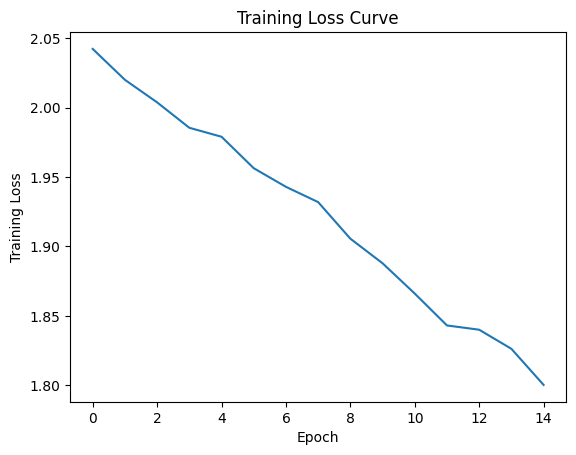

In [11]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()


In [12]:
genders_test = genders_all[len(X_train) + len(X_val):]
cm = evaluate_model(
    model,
    X_test_t,
    y_test_t,
    genders_test
)


Test Accuracy   : 0.3125
Test Macro F1   : 0.2328
Male Macro F1   : nan
Female Macro F1 : nan


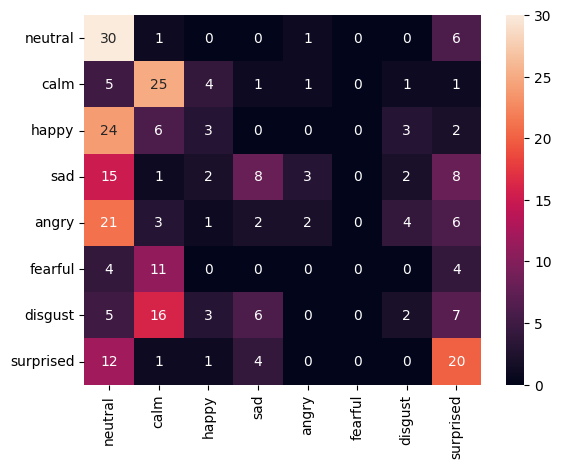

In [13]:
from config import emotion_labels
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.show()


In [14]:
print("Gender distribution in test:", Counter(genders_test))

Gender distribution in test: Counter()
